In [1]:
import numpy as np
import pandas as pd
import json
import argparse
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from itertools import combinations
from utils import *
from models import *

In [2]:
def cor_analysis(low_res_name, super_res_name, iterations):
    
    with open('parameters.json') as json_file:
        parameters = json.load(json_file)
    data_path = parameters['data_path']
    batch_size = parameters['batch_size']
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    ## load data
    data_path = parameters['data_path']
    att_low_res_path = data_path+'attributes/'+low_res_name+'.npy'
    att_super_res_path = data_path+'attributes/'+super_res_name+'.npy'
    linkage_path = data_path+'linkages/'+low_res_name+'_'+super_res_name+'.npy'
    
    ## load data
    X_low = torch.from_numpy(np.load(att_low_res_path)).float()
    X_super = torch.from_numpy(np.load(att_super_res_path)).float()
    linkage = torch.from_numpy(np.load(linkage_path)).float()
    
    ## min-max normalization: min=0
    X_max_low = torch.max(X_low) 
    X_max_super = torch.max(X_super)
    
    X_low = X_low/torch.max(X_low)
    X_low = X_low[:,:,None]
    X_super = X_super/torch.max(X_super)
    X_super = X_super[:,:,None]
    
    ## load model
    model = GraphSR(linkage).to(device)
    criterion = nn.L1Loss().to(device)
    model.load_state_dict(torch.load(f'model_state/graphSR_{low_res_name}_{super_res_name}'))
    
    ## simulation
    mean_super = torch.mean(X_super, dim=0).ravel()
    std_super = torch.std(X_super, dim=0).ravel()
    upper_bounds = 2*mean_super
    corrs = []
    erros = []
    
    for i in tqdm(range(iterations)):
        
        ## correlations
        super_sample = torch.tensor([torch.FloatTensor(1).uniform_(0, 1) for bound in upper_bounds])
        low_sample = torch.sum(super_sample*linkage, dim=1)*X_max_super/X_max_low
        corrs.append(pearsonr(low_sample, torch.mean(X_low, dim=0).ravel())[0])
        
        ## errors
        pred = model(low_sample.to(device).reshape(-1,1)).cpu()
        erros.append(criterion(pred, super_sample.reshape(-1,1)).item())
    
    ## visualization
    plt.figure(figsize=(10,8))
    plt.scatter(corrs, erros)
    plt.xlabel('Correlation', fontsize=18)
    plt.xticks(fontsize=14)
    plt.ylabel('Disaggregation Error', fontsize=18)
    plt.yticks(fontsize=14)
    pass

### PUMA -> NTA

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1550.52it/s]


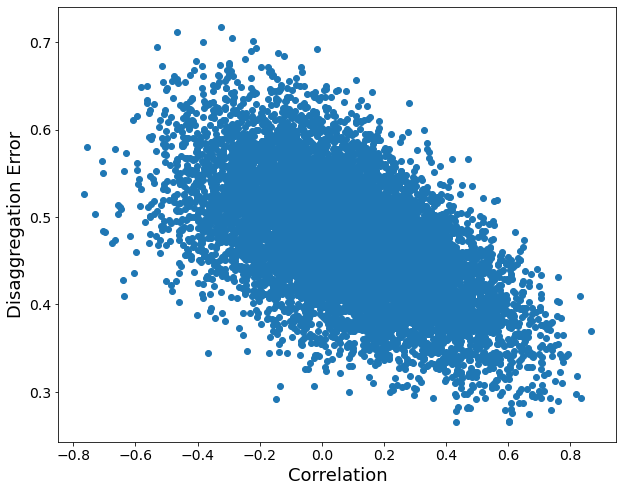

In [3]:
low_res_name = 'puma'
super_res_name = 'nta'
iterations = 10000
cor_analysis(low_res_name, super_res_name, iterations)

### PUMA -> TRACT

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 528.37it/s]


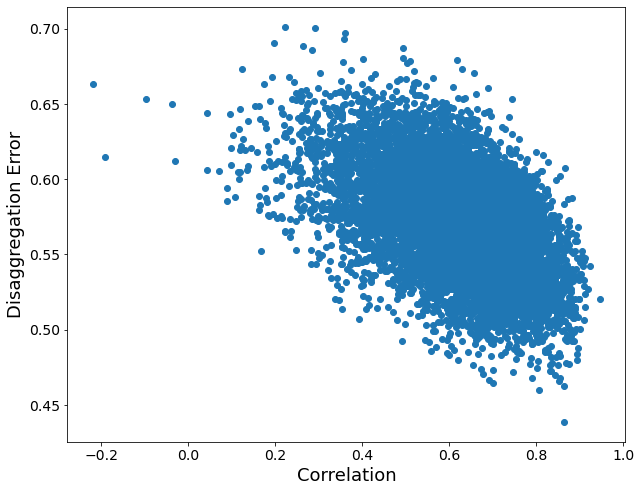

In [4]:
low_res_name = 'puma'
super_res_name = 'tract'
iterations = 10000
cor_analysis(low_res_name, super_res_name, iterations)

### NTA -> TRACT

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 476.58it/s]


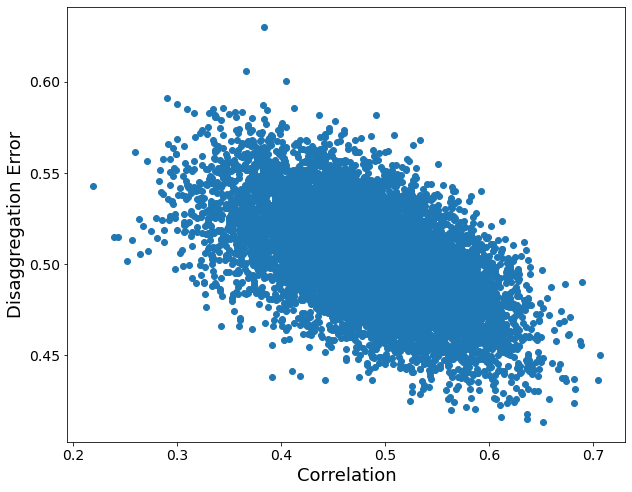

In [5]:
low_res_name = 'nta'
super_res_name = 'tract'
iterations = 10000
cor_analysis(low_res_name, super_res_name, iterations)